In [1]:
# Long Short Term Memory (LSTM) used to predict the closing stock price of NASDAQ:NVDA from 24 October to 4 November (inclusive)
# Using past 100 day stock price

In [2]:
# Import libraries
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math

In [3]:
# Get stock prices from yahoo
df = web.DataReader('NVDA', data_source = 'yahoo', start = '2016-01-01', end = '2022-10-22')

# Display data
df 

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-31,8.372500,8.240000,8.335000,8.240000,14852800.0,8.049900
2016-01-04,8.145000,8.010000,8.072500,8.092500,35807600.0,7.905803
2016-01-05,8.360000,8.125000,8.245000,8.222500,49027200.0,8.032805
2016-01-06,8.125000,7.790000,8.087500,7.882500,44934400.0,7.700648
2016-01-07,7.737500,7.470000,7.685000,7.570000,64530400.0,7.395358
...,...,...,...,...,...,...
2022-10-17,119.480003,115.169998,115.180000,118.879997,58077400.0,118.879997
2022-10-18,124.919998,116.180000,123.440002,119.669998,65936200.0,119.669998
2022-10-19,123.500000,118.339996,118.790001,120.510002,52313100.0,120.510002


In [4]:
# Get num rows and columns in data
df.shape

(1715, 6)

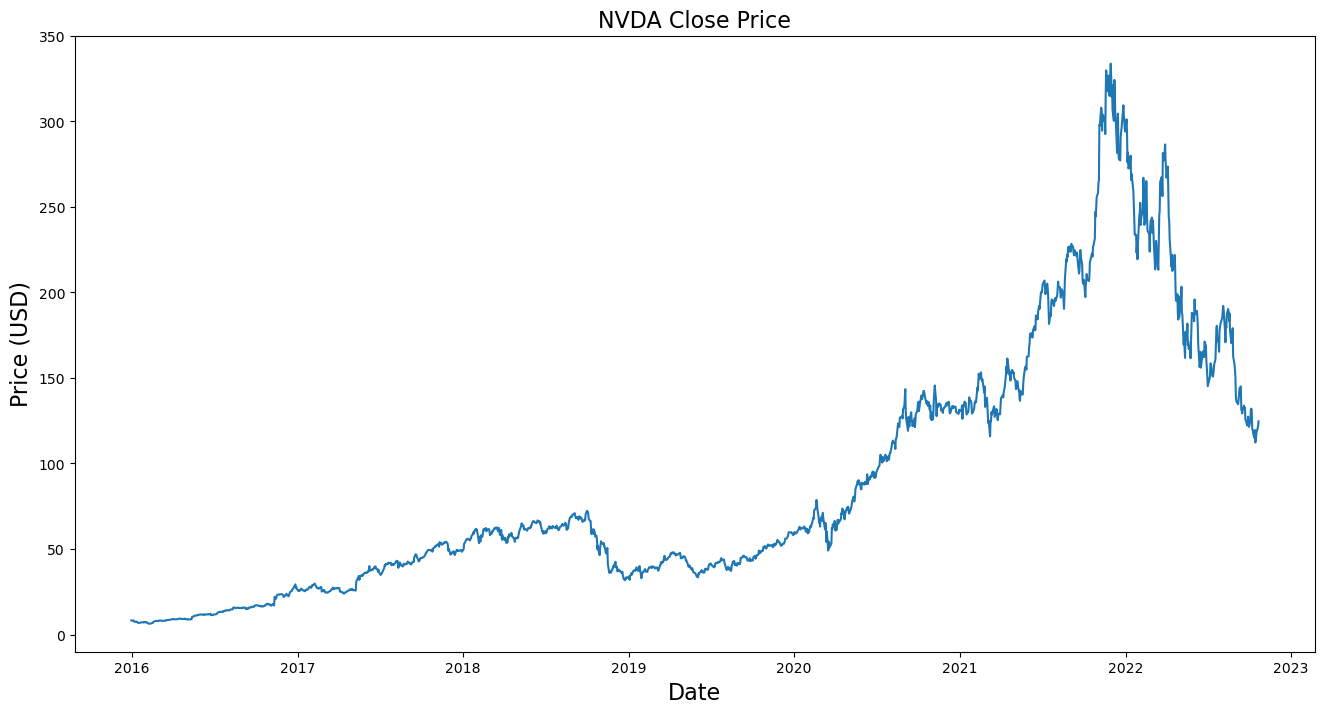

In [5]:
# Visualise the closing price data over time (from Yahoo Finance)
plt.figure(figsize=(16,8)) 
plt.title('NVDA Close Price', fontsize = 16)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Price (USD)', fontsize = 16)
plt.show()


In [6]:
# Create dataframe with only 'Close' price
data = df.filter(['Close'])

# Convert dataframe into numpy array
dataset = data.values 

# Compute the number of rows to train
trainingdata_len = math.ceil(len(dataset) * .75)

trainingdata_len

1287

In [7]:
# Data Processing 
# Scaling the data using MinMaxScaler to make the values range between (0,1) inclusive
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00590921],
       [0.00545876],
       [0.00585577],
       ...,
       [0.34876548],
       [0.35313249],
       [0.36143898]])

In [8]:
# Preparation of Training Dataset
# Create scaled training dataset
train_data = scaled_data[0:trainingdata_len, :]

# Split the data into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0]) 
    y_train.append(train_data[i, 0])

In [9]:
# Convert the x_train and y_train to numpy to be used to train LSTM
x_train = np.array(x_train)
y_train = np.array(y_train)

In [10]:
# Reshape data because LSTM expects the input to be 3 dimensional
# Currently only (row, col)
# Want to make it (row, col, numFeatures)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1227, 60, 1)

In [11]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

2022-10-22 17:12:58.114178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-22 17:12:58.114751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Create the test data
test_data = scaled_data[trainingdata_len - 60: , :]

# Create x_test and y_test
x_test = []
y_test = dataset[trainingdata_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    


In [14]:
# Convert to numpy
x_test = np.array(x_test)

In [15]:
# Reshape data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
# Train the model
model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size=64, epochs=100, verbose = 1)

Epoch 1/100


2022-10-22 17:13:07.782996: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-22 17:13:08.492297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-22 17:13:08.644905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-22 17:13:08.943773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-22 17:13:09.430782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-22 17:13:09.701591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.0065

2022-10-22 17:13:11.349935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-22 17:13:11.401145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-22 17:13:11.466258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 93ms/step - loss: 0.0065 - val_loss: 41868.4258
Epoch 2/100
20/20 [==============================] - 1s 29ms/step - loss: 2.6132e-04 - val_loss: 41818.3438
Epoch 3/100
20/20 [==============================] - 1s 29ms/step - loss: 1.5227e-04 - val_loss: 41837.0859
Epoch 4/100
20/20 [==============================] - 1s 29ms/step - loss: 1.2701e-04 - val_loss: 41838.8789
Epoch 5/100
20/20 [==============================] - 1s 29ms/step - loss: 1.2245e-04 - val_loss: 41839.7031
Epoch 6/100
20/20 [==============================] - 1s 29ms/step - loss: 1.2255e-04 - val_loss: 41840.0703
Epoch 7/100
20/20 [==============================] - 1s 29ms/step - loss: 1.2981e-04 - val_loss: 41847.8594
Epoch 8/100
20/20 [==============================] - 1s 29ms/step - loss: 1.2910e-04 - val_loss: 41847.5352
Epoch 9/100
20/20 [==============================] - 1s 29ms/step - loss: 1.1878e-04 - val_loss: 41846.2539
Epoch 10/100
20/20 [========================

In [17]:
# Get the models predicted price values
predictions = model.predict(x_test)

## Unscale the data
predictions = scaler.inverse_transform(predictions)

 1/14 [=>............................] - ETA: 4s

2022-10-22 17:20:34.674120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-22 17:20:34.721554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-22 17:20:34.785503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 33ms/step


In [18]:
# Get rmse to evaluate our backtest
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3.0977953081933136

/var/folders/80/9f7spzks4sg_457d93krxvcm0000gn/T/ipykernel_84737/4124331198.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


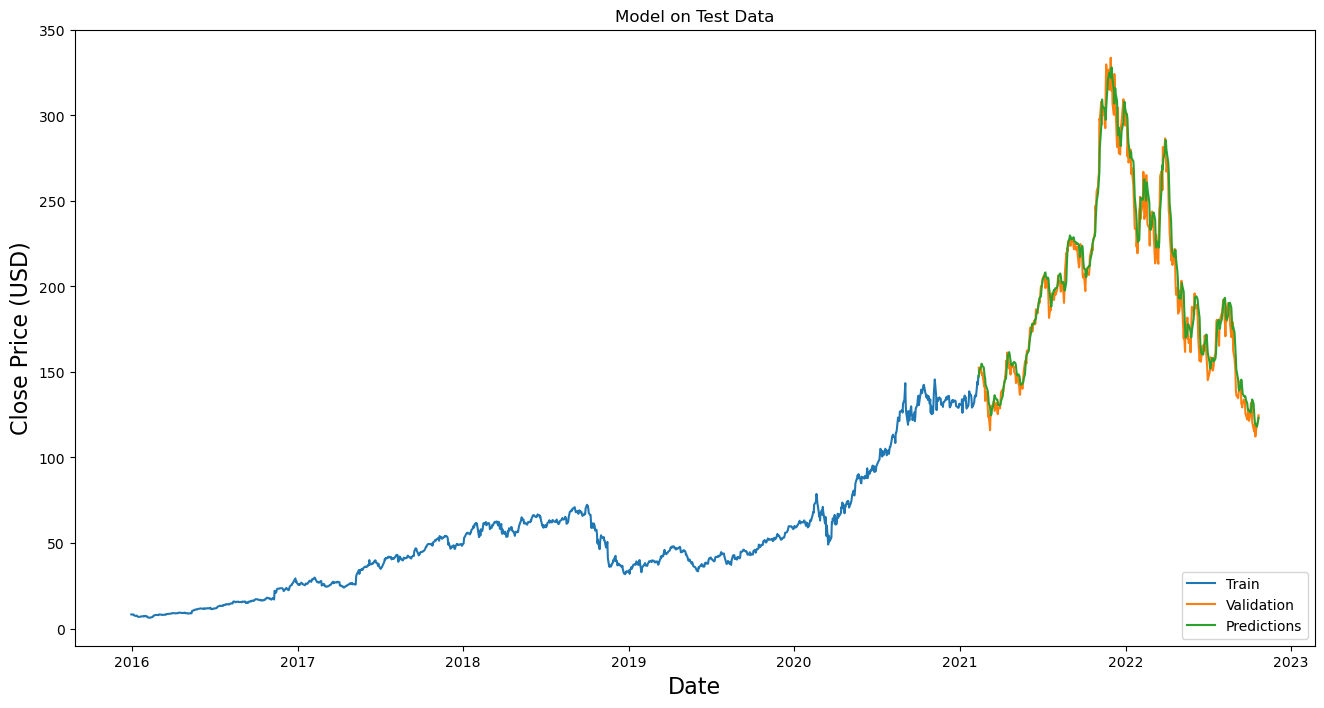

In [19]:
# Plot our predictions overlayed on the actual 
train = data[:trainingdata_len]
valid = data[trainingdata_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model on Test Data')
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Close Price (USD)', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

In [20]:
len(test_data)

488

In [30]:
# Get the last 100 days' worth of data 
# To predict the next 11 days
x_input=test_data[len(test_data) - 60:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [31]:
# Predict next 11 days
# Predict the next day, put that value back into the input for the next prediction
lst_output = []
days_to_predict = 12
n_steps = 60
i = 0
while(i < days_to_predict):
    if(len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.3634135]
61
1 day input [0.54390679 0.54650254 0.55771018 0.5675436  0.5606419  0.52411778
 0.50252705 0.53340152 0.52866804 0.5520911  0.56195508 0.55728264
 0.54066971 0.55404556 0.52582798 0.50093903 0.5054282  0.5066803
 0.52778244 0.47730223 0.463285   0.45311566 0.44169427 0.40636115
 0.39750499 0.39194696 0.39955107 0.40797969 0.4201035  0.42370707
 0.38174709 0.38165548 0.37557829 0.38379317 0.3894123  0.38312132
 0.38571711 0.36434013 0.3629659  0.35417079 0.35982041 0.36968438
 0.35392647 0.35145286 0.36284375 0.38284648 0.38412909 0.38171657
 0.34952894 0.33713027 0.33456505 0.33193873 0.34598646 0.3236017
 0.34378768 0.34620023 0.34876548 0.35313249 0.36143898 0.36341351]
1 day output [[0.36886746]]
2 day input [0.54650254 0.55771018 0.5675436  0.5606419  0.52411778 0.50252705
 0.53340152 0.52866804 0.5520911  0.56195508 0.55728264 0.54066971
 0.55404556 0.52582798 0.50093903 0.5054282  0.5066803  0.52778244
 0.47730223 0.463285   0.45311566 0.44169427 0.40636115 0.39750

In [61]:
# View predicted value
predicted = scaler.inverse_transform(lst_output)
df3 = pd.DataFrame(predicted, columns=["Forecasted Prices (USD)"])
date = ["2022-10-24", "2022-10-25", "2022-10-26", "2022-10-27", "2022-10-28", "2022-10-29", "2022-10-30", "2022-10-31", "2022-11-01", "2022-11-02", "2022-11-03", "2022-11-04"]
df3["Date"] = date
df3 = df3[["Date", "Forecasted Prices (USD)"]]
df3["Date"] = pd.to_datetime(df3["Date"], format='%Y-%m-%d', errors='coerce')
df3 = df3.set_index("Date")
df3 = df3.drop(["2022-10-29","2022-10-30"]) ## remove the weekends when market is closed

# convert to csv
df3.to_csv (r'/Users/bryanwonggy/FintechSociety/ML Project 1 - NVDA Price Prediction/BryanWongJunLin_Impl_1.csv', index = True, header=True)
df3

,Forecasted Prices (USD)
Date,
2022-10-24,125.306575
2022-10-25,127.092497
2022-10-26,128.788021
2022-10-27,130.431423
2022-10-28,132.032335
2022-10-31,136.594113
2022-11-01,138.040726
2022-11-02,139.456619
2022-11-03,140.846669


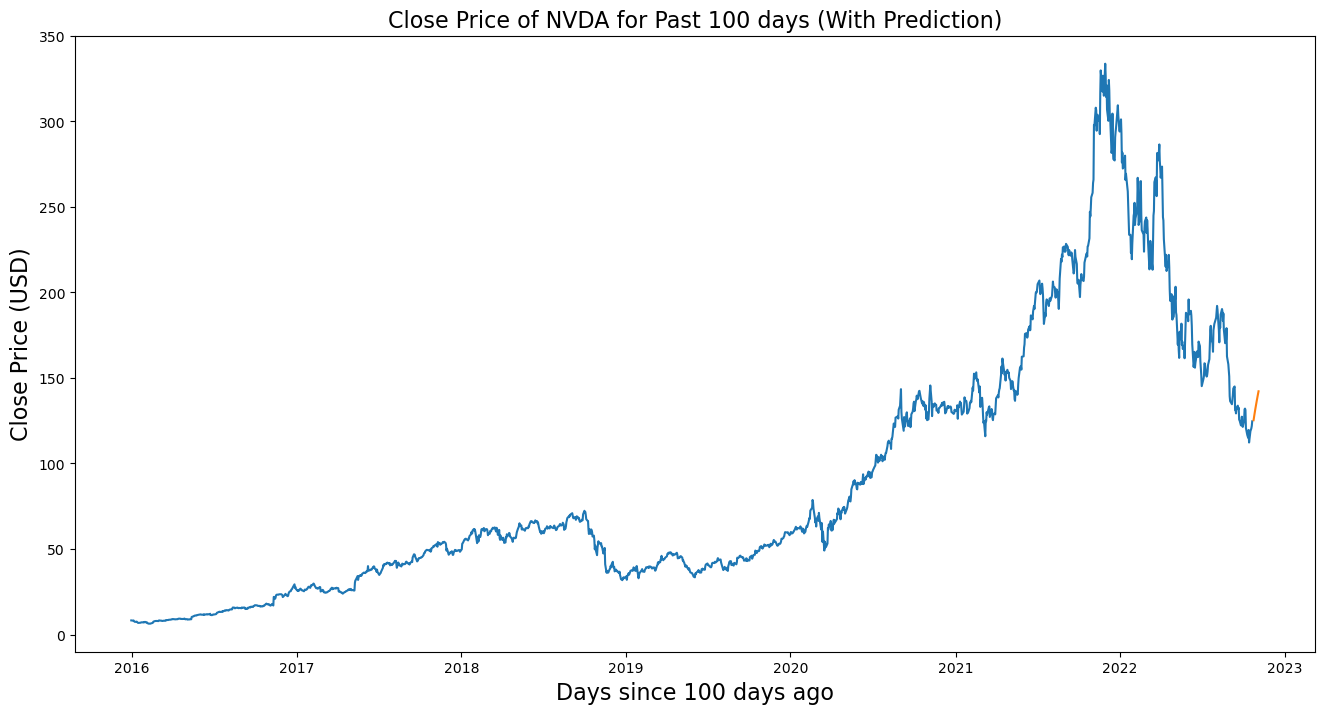

In [59]:
# Visualise our prediction
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.plot(df3["Forecasted Prices (USD)"])
plt.title('Close Price of NVDA for Past 100 days (With Prediction)', fontsize = 16)
plt.ylabel('Close Price (USD)', fontsize=16)
plt.xlabel('Date', fontsize = 16)
plt.show()